# FNN Digit Recognition

## Import dependencies

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import tensorflowjs as tfjs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loads the MNIST dataset

This is a dataset of 60,000 - 28x28 **grayscale** images of the 10 digits,
 along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).

![MNIST sample](https://github.com/khanhlvg/DigitClassifier/raw/master/images/mnist.png)

In [3]:
# load misnt dataset from keras
mnist = keras.datasets.mnist
# store it into train and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

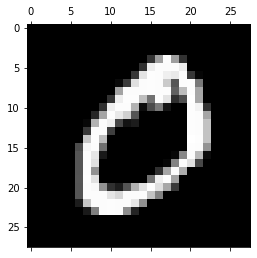

In [4]:
plt.matshow(train_images[1], cmap="gray")
plt.show()

We can see that the background is colored in black and the digits are colored in white, but this is not how the model gets its input.
Usually, digits are written in black in a white background, so we will adjust our training data to reflect that.

In [5]:
# normalize training and testing images
# and reverse the color of the images
train_images = 1 - (train_images / 255.0)
train_labels = train_labels
test_images = 1 - (test_images / 225.0)
test_labels = test_labels

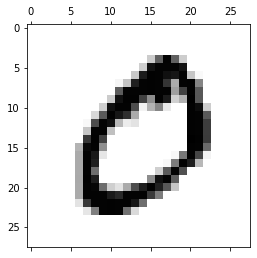

In [6]:
# after reversing
plt.matshow(train_images[1], cmap="gray")
plt.show()

28x28 grayscale and 60K samples in the train input.
we need to reshape the dataset. into 2D
- **Columns**: represents the samples (M)
- **Rows**: represents the features (Nx)

In [7]:
def reshape_input(input):
    """
    reshape the 3D input into 2D.

    Args:
      input: np.array

    Return:
      flattened_input: np.array
    """
    num_of_features = input.shape[1] * input.shape[2]
    num_of_samples = input.shape[0]
    flattened_input = input.reshape(num_of_samples, num_of_features)

    return flattened_input

In [8]:
# reshape inputs train/test
train_images_flattened = reshape_input(train_images)
test_images_flattened = reshape_input(test_images)

train_images_flattened.shape, test_images_flattened.shape

((60000, 784), (10000, 784))

## Building the Model

We decided to add noise to the training images because the new sample will come from different distribution by adding some noise to the data that somehow will make the training data close to the new sample that they will come later

In [9]:
def modeling(units, dropout, learning_rate):
    model = keras.Sequential(name="Digit-Recognizer")
    model.add(
        keras.layers.Dense(
            units=units,
            input_dim=train_images_flattened.shape[1],
            activation="relu",
            name="hidden_layer_1",
        )
    )
    # adding noise to the training images
    model.add(keras.layers.GaussianNoise(0.075))
    # regularization
    if dropout:
        model.add(keras.layers.Dropout(rate=0.25))
    # output layer 10 digits ( classes )
    model.add(keras.layers.Dense(units=10, activation="softmax", name="output_layer_2"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


def build_model(hp):
    units = hp.Int("units", min_value=128, max_value=512, step=16)
    dropout = hp.Boolean("dropout")
    learning_rate = hp.Float(
        "learning_rate", min_value=1e-4, max_value=1e-2, sampling="log"
    )

    model = modeling(units=units, dropout=dropout, learning_rate=learning_rate)

    return model


stop_early = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

In [10]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="DR-TRIALS",
    project_name="Digit Recognizer",
)

In [11]:
tuner.search(
    train_images_flattened,
    train_labels,
    epochs=20,
    validation_split=0.2,
    callbacks=[stop_early],
)

Trial 10 Complete [00h 03m 01s]
accuracy: 0.37027083337306976

Best accuracy So Far: 0.9781145751476288
Total elapsed time: 00h 48m 08s
INFO:tensorflow:Oracle triggered exit


In [20]:
# get the summary for the top 2
tuner.results_summary(2)

Results summary
Results in DR-TRIALS/Digit Recognizer
Showing 2 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
units: 384
dropout: False
learning_rate: 0.0005034672825968825
Score: 0.9781145751476288
Trial summary
Hyperparameters:
units: 336
dropout: False
learning_rate: 0.001808505727398475
Score: 0.9672395884990692


In [21]:
# store best model
model = tuner.get_best_models()[0]

In [22]:
model.summary()

Model: "Digit-Recognizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 384)               301440    
                                                                 
 gaussian_noise (GaussianNoi  (None, 384)              0         
 se)                                                             
                                                                 
 output_layer_2 (Dense)      (None, 10)                3850      
                                                                 
Total params: 305,290
Trainable params: 305,290
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.evaluate(test_images_flattened, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0881 - accuracy: 0.9735


[0.08809848874807358, 0.9735000133514404]

In [24]:
predicted_images = model.predict(test_images_flattened)
predicted_labels = [np.argmax(predicted_digit) for predicted_digit in predicted_images]
print("Predicted Digits: ", predicted_labels[:5])
print("Actual Digits: ", test_labels[:5])

Predicted Digits:  [7, 2, 1, 0, 4]
Actual Digits:  [7 2 1 0 4]


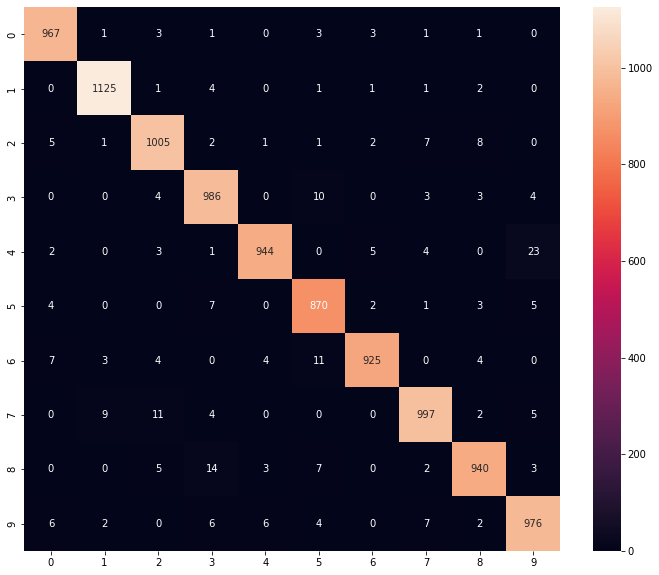

In [25]:
confusion_matrix = tf.math.confusion_matrix(
    labels=test_labels, predictions=predicted_labels, num_classes=10
)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.show()

## Retrain the model

In [37]:
# get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
# build the model with the best hyperparameters
model = build_model(best_hps)
# concatenate train and test images, labels
all_images = np.concatenate((train_images_flattened, test_images_flattened))

all_labels = np.concatenate((train_labels, test_labels))

# fit the model with all images
model.fit(x=all_images, y=all_labels, epochs=10)

Epoch 1/10
2188/2188 [==============================] - 11s 5ms/step - loss: 0.4597 - accuracy: 0.8629
Epoch 2/10
2188/2188 [==============================] - 12s 6ms/step - loss: 0.2782 - accuracy: 0.9171
Epoch 3/10
2188/2188 [==============================] - 14s 6ms/step - loss: 0.2068 - accuracy: 0.9379
Epoch 4/10
2188/2188 [==============================] - 15s 7ms/step - loss: 0.1676 - accuracy: 0.9500
Epoch 5/10
2188/2188 [==============================] - 11s 5ms/step - loss: 0.1468 - accuracy: 0.9557
Epoch 6/10
2188/2188 [==============================] - 9s 4ms/step - loss: 0.1303 - accuracy: 0.9602
Epoch 7/10
2188/2188 [==============================] - 9s 4ms/step - loss: 0.1174 - accuracy: 0.9643
Epoch 8/10
2188/2188 [==============================] - 10s 4ms/step - loss: 0.1091 - accuracy: 0.9656
Epoch 9/10
2188/2188 [==============================] - 10s 5ms/step - loss: 0.1004 - accuracy: 0.9689
Epoch 10/10
2188/2188 [==============================] - 11s 5ms/step - los

## Save Model

In [38]:
# save the model
model.save("Keras-784x10-5epoch")
# convert the model into tfjs
tfjs.converters.save_keras_model(model, "model_v04")

INFO:tensorflow:Assets written to: Keras-784x10-5epoch/assets
